In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM,SimpleRNN,Dropout
from keras.callbacks import History


import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM


import time #helper libraries
from sklearn.preprocessing import MinMaxScaler

from numpy import newaxis

import time

# For time stamps
from datetime import datetime

#for dataset
import yfinance as yf

In [2]:
stock_data = pd.read_csv('TCS.NS.csv')

In [3]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-02,111.949997,114.500000,105.699997,110.900002,84.214729,9283.0
1,2012-01-03,110.650002,116.000000,106.650002,111.849998,84.936127,15330.0
2,2012-01-04,110.000000,116.250000,108.099998,115.199997,87.480042,5844.0
3,2012-01-05,115.300003,116.400002,112.050003,114.099998,86.644730,12400.0
4,2012-01-06,114.900002,114.900002,110.150002,113.349998,86.075180,1368.0


In [4]:
stock_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
stock_data.dropna(inplace=True)

# Printing df
stock_data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-02,111.949997,114.500000,105.699997,110.900002,84.214729,9283.0
1,2012-01-03,110.650002,116.000000,106.650002,111.849998,84.936127,15330.0
2,2012-01-04,110.000000,116.250000,108.099998,115.199997,87.480042,5844.0
3,2012-01-05,115.300003,116.400002,112.050003,114.099998,86.644730,12400.0
4,2012-01-06,114.900002,114.900002,110.150002,113.349998,86.075180,1368.0
...,...,...,...,...,...,...,...
2714,2022-12-26,785.000000,819.700012,780.700012,814.500000,814.500000,93019.0
2715,2022-12-27,818.799988,823.000000,810.000000,816.549988,816.549988,34735.0
2716,2022-12-28,814.000000,826.799988,811.650024,821.200012,821.200012,49240.0
2717,2022-12-29,813.799988,823.450012,812.849976,817.049988,817.049988,35258.0


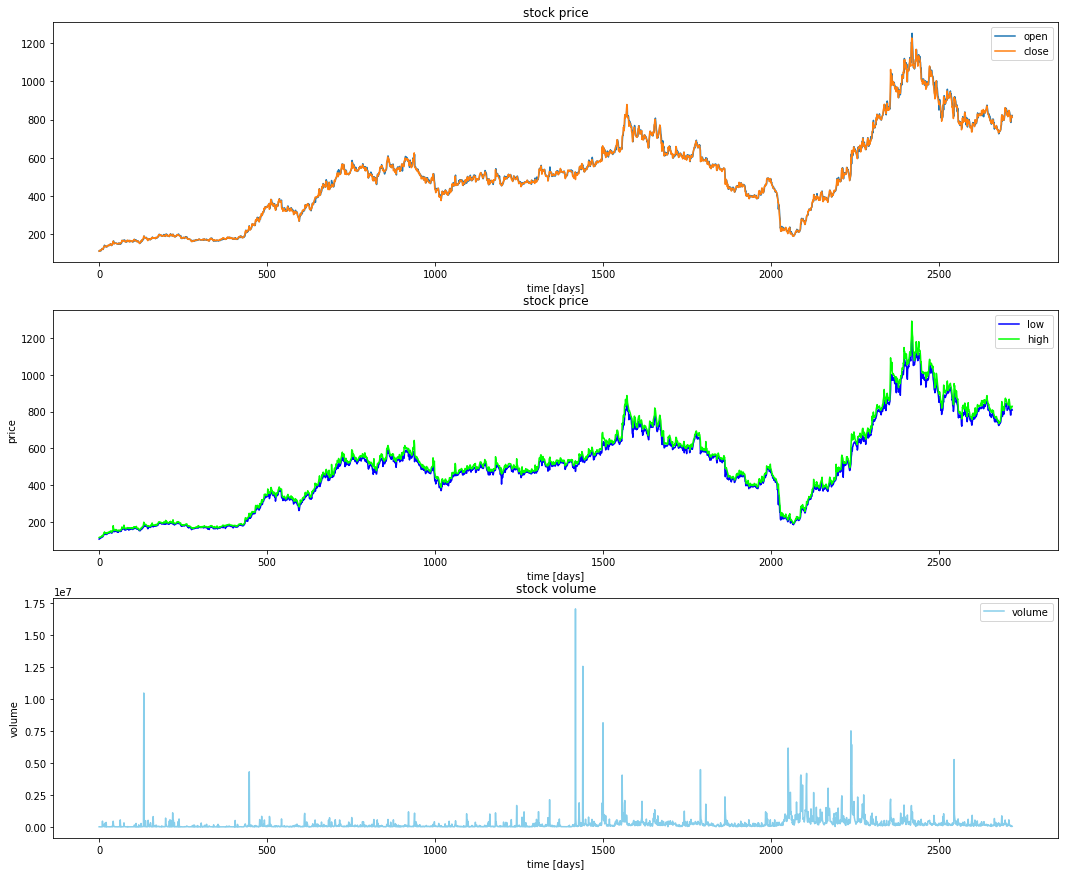

In [5]:
plt.figure(figsize=(18,15));
plt.subplot(3,1,1)
plt.plot(stock_data['Open'], label='open')
plt.plot(stock_data['Close'], label='close')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(stock_data['Low'], color='blue', label='low')
plt.plot(stock_data['High'], color='lime', label='high')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(3,1,3)
plt.plot(stock_data['Volume'], color='skyblue', label='volume')
#plt.gca().invert_xaxis()
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [6]:
stock_data.shape


(2713, 7)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [8]:
#splitting the data
close_prices= stock_data.filter(['Close']) #creates a dataframe just with specified column( close )
values = close_prices.values
training_data_len = math.ceil(len(values) * 0.8)

In [9]:
scaled_data=scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len,:]

In [10]:
window_size = 60
x_train=[]
y_train=[]
for i in range(window_size,len(train_data)):
  x_train.append(train_data[i-window_size:i,0])
  y_train.append(train_data[i,0])

In [11]:
x_train,y_train=np.array(x_train),np.array(y_train)


In [12]:
test_data = scaled_data[training_data_len - window_size: , :]
x_test=[]
y_test= values[training_data_len:]
for j in range(window_size,len(test_data)):
  x_test.append(test_data[j-window_size:j,0])

x_test=np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [13]:

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2111, 60)
y_train.shape =  (2111,)
x_test.shape =  (542, 60, 1)
y_test.shape =  (542, 1)


In [14]:
#Building the model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='tanh'), input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.build((x_train.shape[1],1)) 
model.add(Dense(1))

In [15]:
start = time.time()
model.compile(loss='mse',  optimizer='adam', metrics=['accuracy'])
print ('compilation time : ', time.time() - start)

compilation time :  0.030772924423217773


In [16]:
history=model.fit(x_train, y_train, epochs=50, batch_size=32,validation_split=0.2,  verbose=1 , shuffle=True)


Epoch 1/50
53/53 [==============================] - 6s 41ms/step - loss: 0.0142 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 3/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 5/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/50
53/53 [==============================] - 1s 25ms/step - loss: 9.2112e-04 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 7/50
53/53 [==============================] - 1s 25ms/step - loss: 9.1787e-04 - accuracy: 0.0000

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 [==============================] - 1s 8ms/step


In [18]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = np.mean(predictions - y_test)**2
from sklearn.metrics import r2_score
#R2 = r2_score(y_test, predictions, multioutput='variance_weighted')
print('RMSE : ',rmse)
print('MSE : ',mse)
#print('R2 : ',R2)

RMSE :  20.401651006558463
MSE :  416.22736379340796


In [19]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, predictions)
print(mape)

0.03065157526556948


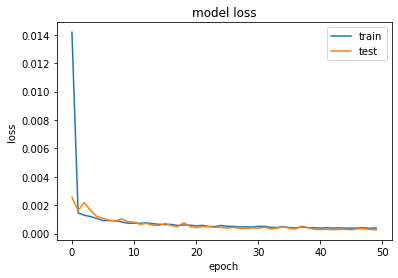

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


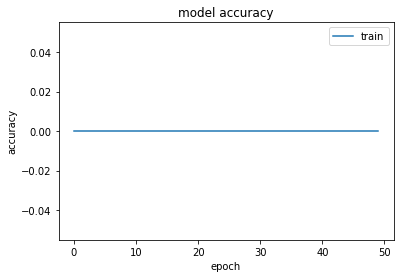

In [21]:
print(history.history.keys())

# summarize history for accuracy

plt.size=(10,5)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [22]:
print('accuracy =',history.history['accuracy'][-1])

accuracy = 0.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_23300\4220012384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


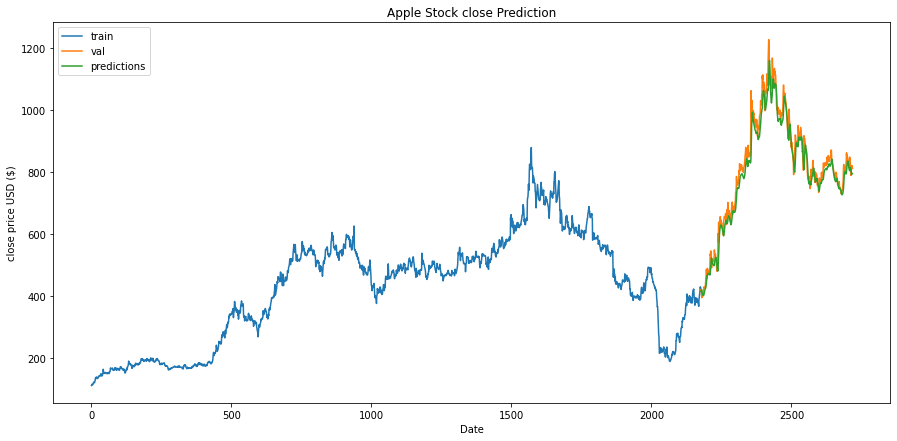

In [23]:
data1 = stock_data.filter(['Close'])
train= data1[:training_data_len]
validation = data1[training_data_len:]
validation['predictions'] = predictions

plt.figure(figsize=(15, 7))
plt.title('Apple Stock close Prediction')
plt.xlabel('Date')
plt.ylabel('close price USD ($)')
plt.plot(train)
plt.plot(validation[['Close','predictions']])
plt.legend(['train','val','predictions'],loc='upper left')
plt.show()

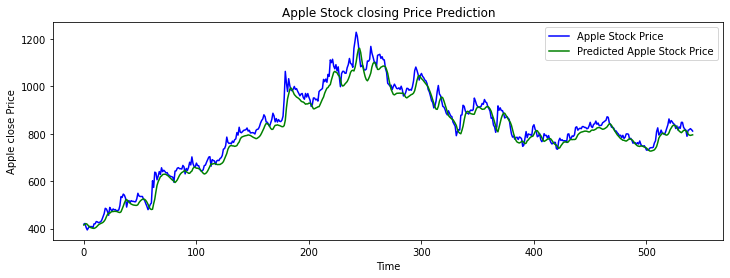

In [24]:
plt.figure(figsize=(12, 4))

real_stock_price = y_test[:]
plt.plot(real_stock_price, color='blue', label='Apple Stock Price')
plt.plot(predictions, color='green', label='Predicted Apple Stock Price')

plt.title('Apple Stock closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple close Price')
plt.legend()
plt.show()
     